In [1]:
#MAIN LOOP - where we run the simulations to figure out statistical significance of changes

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import netCDF4 as nc
%matplotlib notebook
%load_ext autotime
from bootstrap import *
import numpy.ma as ma
from chr_matplotlib import remappedColorMap

In [2]:
ferretpath = "/Users/Siwen/Desktop/ferret/bin/"
ff = "Pchina_type_notaiwan.nc"
filename = ferretpath + ff
myf = nc.Dataset(filename, 'r')

time: 27.3 ms


In [3]:
P_total =  myf.variables['Pchina_total'][:]
P_band = myf.variables['Pchina_band'][:]
P_local = myf.variables['Pchina_local'][:]

time: 84.7 ms


In [4]:
def smooth(P,dayrange,latrange):
    Psmooth=np.zeros(P.shape)
    
    ll=int((dayrange-1)/2)
    yy=int((latrange-1)/2)
    
    days = P.shape[0]
    lats = P.shape[1]
    
    for d in range(days):
        for j in range(lats):
            
            Psample = P.take(range(d-ll,d+ll+1), mode='wrap', axis=0)
            Ps = Psample[:,max(0,j-yy):min(days,j+yy+1)]
            Psmooth[d,j] = np.mean(np.mean(Ps))
    
    return Psmooth

time: 7.7 ms


In [5]:
#years of interest - start and end date, with index starting at 1 out of habit.
p1_yr_b = [1,30]
p1_yr_e = [29,43]
p2_yr_b = [30,44]
p2_yr_e = [57,57]

P_total_diff = []
P_band_diff = []
P_local_diff = []

#cycle through all time periods of interest and find changes in each type of rainfall b/w periods
for p1_b, p1_e, p2_b, p2_e, i in zip(p1_yr_b, p1_yr_e, p2_yr_b, p2_yr_e, np.arange(len(p1_yr_b))): 
    
    P_total_diff.append(np.mean(P_total[:,:,p2_b-1:p2_e], axis=2) - \
                         np.mean(P_total[:,:,p1_b-1:p1_e], axis=2))
    P_band_diff.append(np.mean(P_band[:,:,p2_b-1:p2_e], axis=2) \
                       - np.mean(P_band[:,:,p1_b-1:p1_e], axis=2))
    P_local_diff.append(np.mean(P_local[:,:,p2_b-1:p2_e], axis=2) \
                        - np.mean(P_local[:,:,p1_b-1:p1_e], axis=2))

time: 20.9 ms


In [6]:
## SMOOTHING ##
#smooth out the decadal precipitation means
#but, no latitudinal smoothing since rainfall already effectively smoothed in latitude
daysmth = 15
latsmth = 0

#one line! thank you python!
P_total_diff_smth = [ smooth(x,daysmth,latsmth) for x in P_total_diff ]
P_band_diff_smth = [ smooth(x,daysmth,latsmth) for x in P_band_diff ]
P_local_diff_smth = [ smooth(x,daysmth,latsmth) for x in P_local_diff ]

time: 4.63 s


In [7]:
## LOAD COMPUTED P-VALUES ##

#which set of sim values are we trying to access?
pval_root = 'chinarain_diff_pval_notaiwan_'
blklen = 2
niter = 2000

P_total_diff_pval = []
P_band_diff_pval = []
P_local_diff_pval = []

#cycle through all time periods of interest and find changes in each type of rainfall b/w periods
for p1_b, p1_e, p2_b, p2_e, i in zip(p1_yr_b, p1_yr_e, p2_yr_b, p2_yr_e, np.arange(len(p1_yr_b))): 
    
    #LOAD P-VALUES FOR TOTAL RAINFALL
    raintype = 'total'
    yrs = str(p1_b+50) + str(p1_e+50) + '_' + str(p2_b+50) + str(p2_e+50) + '_'
    pval_filename = pval_root + yrs + raintype + '_' + str(blklen) + 'day_' \
        + str(niter) + 'iter.nc'
    
    if os.path.isfile(pval_filename):
        print(pval_filename + ' found')
        myf = nc.Dataset(pval_filename, 'r')
        P_total_diff_pval.append(myf.variables['pval'][:])
        myf.close()
        
    else:
        print(pval_filename + ' does not exist')
    
    
    ##LOAD P-VALUES FOR BANDED RAINFALL
    raintype = 'band'
    yrs = str(p1_b+50) + str(p1_e+50) + '_' + str(p2_b+50) + str(p2_e+50) + '_'
    pval_filename = pval_root + yrs + raintype + '_' + str(blklen) + 'day_' \
        + str(niter) + 'iter.nc'
    
    if os.path.isfile(pval_filename):
        print(pval_filename + ' found')
        myf = nc.Dataset(pval_filename, 'r')
        P_band_diff_pval.append(myf.variables['pval'][:])
        myf.close()
        
    else:
        print(pval_filename + ' does not exist')
            
    ##LOAD P-VALUES FOR LOCAL RAINFALL
    raintype = 'local'
    yrs = str(p1_b+50) + str(p1_e+50) + '_' + str(p2_b+50) + str(p2_e+50) + '_'
    pval_filename = pval_root + yrs + raintype + '_' + str(blklen) + 'day_' \
        + str(niter) + 'iter.nc'
    
    if os.path.isfile(pval_filename):
        print(pval_filename + ' found')
        myf = nc.Dataset(pval_filename, 'r')
        P_local_diff_pval.append(myf.variables['pval'][:])
        myf.close()
        
    else:
        print(pval_filename + ' does not exist')    
        
    #P_total_diff.append()
    #P_band_diff.append(np.mean(P_band[:,:,p2_b-1:p2_e], axis=2) \
    #P_local_diff.append(np.mean(P_local[:,:,p2_b-1:p2_e], axis=2) \


chinarain_diff_pval_notaiwan_5179_80107_total_2day_2000iter.nc found
chinarain_diff_pval_notaiwan_5179_80107_band_2day_2000iter.nc found
chinarain_diff_pval_notaiwan_5179_80107_local_2day_2000iter.nc found
chinarain_diff_pval_notaiwan_8093_94107_total_2day_2000iter.nc found
chinarain_diff_pval_notaiwan_8093_94107_band_2day_2000iter.nc found
chinarain_diff_pval_notaiwan_8093_94107_local_2day_2000iter.nc found
time: 85.7 ms


In [8]:
## CREATE MASKED ARRAYS - only show values that are statistically significant
#create two masked arrays - one showing 95% confidence, one showing 99% confidence

##two separate for loops: first one creates masks, second one produces masked rainfall.
#reason for doing things this way is that masks can then be accessed at a later point in time.

#not super-pythonic method, but at least it makes it easy to understand.

mk_total = [] #storage format will be a LIST of 2-element tuples - each set of tuples is the 95% and 99% mask respectively
mk_band = []
mk_local = []

#cycle through each of the different time periods of interest
for P_total_diff, P_band_diff, P_local_diff, P_total_pval, P_band_pval, P_local_pval in \
    zip(P_total_diff_smth, P_band_diff_smth, P_local_diff_smth, P_total_diff_pval, P_band_diff_pval, P_local_diff_pval):
    
    mk_total_95 = abs(P_total_pval-.5) < .475 #95th percentile mask for rainfall changes
    mk_total_99 = abs(P_total_pval-.5) < .495 #99th percentile mask for rainfall changes
    mk_total.append((mk_total_95,mk_total_99))
    
    mk_band_95 = abs(P_band_pval-.5) < .475 #95th percentile mask for rainfall changes
    mk_band_99 = abs(P_band_pval-.5) < .495 #99th percentile mask for rainfall changes
    mk_band.append((mk_band_95,mk_band_99))
    
    mk_local_95 = abs(P_local_pval-.5) < .475 #95th percentile mask for rainfall changes
    mk_local_99 = abs(P_local_pval-.5) < .495 #99th percentile mask for rainfall changes
    mk_local.append((mk_local_95,mk_local_99))
    
#create masked arrays
P_total_diff_mask = []
P_band_diff_mask = []
P_local_diff_mask = []

for P_total_diff, P_band_diff, P_local_diff, mask_total, mask_band, mask_local in \
    zip(P_total_diff_smth, P_band_diff_smth, P_local_diff_smth, mk_total, mk_band, mk_local):
    
    P_total_diff_mask.append(ma.array(P_total_diff, mask = mask_total[0]))
    P_band_diff_mask.append(ma.array(P_band_diff, mask = mask_band[0]))
    P_local_diff_mask.append(ma.array(P_local_diff, mask = mask_local[0]))
    
#P_total_diff_smth_mask = [ print(x.shape) for (x,y) in zip(P_total_diff_smth,P_total_diff_pval) ]
#P_total_diff_smth_mask = [ ma.array(x,mask = abs(y)-.5 > .475) for (x,y) in zip(P_total_diff_smth,P_total_diff_pval) ]
#P_band_diff_smth_mask = [ smooth(x,daysmth,latsmth) for x in P_band_diff_smth ]
#P_local_diff_smth_mask = [ smooth(x,daysmth,latsmth) for x in P_local_diff_smth ]

time: 20.7 ms


In [9]:
axmax = max(np.max(P_total_diff_mask[0]),np.max(P_band_diff_mask[0]),np.max(P_local_diff_mask[0]))
axmin = min(np.min(P_total_diff_mask[0]),np.min(P_band_diff_mask[0]),np.min(P_local_diff_mask[0]))

axlim = max(axmax,-axmin)

time: 3.79 ms


In [10]:
plt.cm.get_cmap('bwr')

time: 2.87 ms


In [11]:
remap_start = 0
remap_mid = (abs(axmin))/(axmax+abs(axmin))
remap_stop = 1-(abs(axmin)-axmax)/(2*abs(axmin))

print(remap_mid)
print(remap_stop)

cmap_test = remappedColorMap(plt.cm.get_cmap('bwr_r'), start=0, midpoint=remap_mid, stop=remap_stop)


0.553836462269
0.902793575474
time: 13.3 ms


<IPython.core.display.Javascript object>


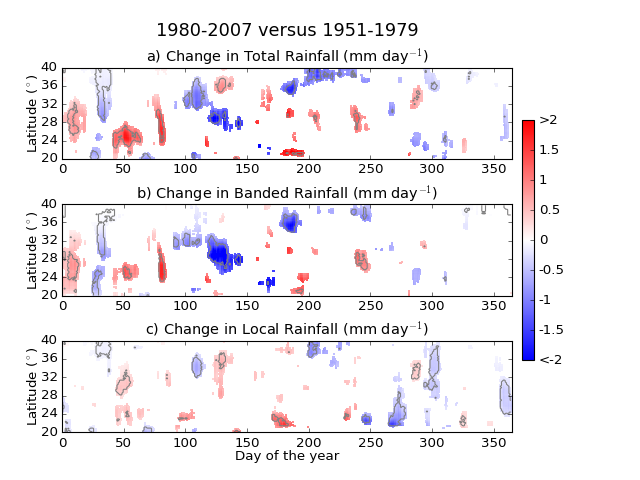

Overwriting existing version of file...
time: 12.4 s


In [12]:
## CREATE FIGURE OF 1951-1979 v 1980-2007 changes

#axlim = max(np.max(abs(P_total_diff_mask[0])),np.max(abs(P_band_diff_mask[0])),np.max(abs(P_local_diff_mask[0])))
axlim = 2
mypalette = 'bwr'

fig, ax = plt.subplots()
ax.set_title("1980-2007 versus 1951-1979", fontsize=16, y = 1.07)

ax1 = fig.add_subplot(3,1,1)
plot1 = ax1.pcolormesh(P_total_diff_mask[0].T, cmap = mypalette, vmin = -axlim, vmax = axlim); 
plt.contour(mk_total[0][1].T,1,colors = 'gray')
ax1.set_title("a) Change in Total Rainfall (mm day$^{-1}$)", fontsize=13)
#plt.xlabel('Day of the year', fontsize=12, labelpad=0)
plt.ylabel('Latitude ($^\circ$)', fontsize=12, labelpad=0)
plt.yticks(np.linspace(0,80,6),np.linspace(20,40,6).astype(int))

ax2 = fig.add_subplot(3,1,2)
plot2 = ax2.pcolormesh(P_band_diff_mask[0].T, cmap = mypalette, vmin = -axlim, vmax = axlim); 
plt.contour(mk_band[0][1].T,1,colors = 'gray')
ax2.set_title("b) Change in Banded Rainfall (mm day$^{-1}$)", fontsize=13)
#plt.xlabel('Day of the year', fontsize=12, labelpad=0)
plt.ylabel('Latitude ($^\circ$)', fontsize=12, labelpad=0)
plt.yticks(np.linspace(0,80,6),np.linspace(20,40,6).astype(int))


ax3 = fig.add_subplot(3,1,3)
plot3 = ax3.pcolormesh(P_local_diff_mask[0].T, cmap = mypalette, vmin = -axlim, vmax = axlim); 
plt.contour(mk_local[0][1].T,1,colors = 'gray')
ax3.set_title("c) Change in Local Rainfall (mm day$^{-1}$)", fontsize=13)
plt.xlabel('Day of the year', fontsize=12, labelpad=0)
plt.ylabel('Latitude ($^\circ$)', fontsize=12, labelpad=0)
plt.yticks(np.linspace(0,80,6),np.linspace(20,40,6).astype(int))

plt.tight_layout(pad=0, w_pad=0, h_pad=.5)
ax.set_axis_off()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([.815, 0.25, 0.02, 0.5])
cbar = fig.colorbar(plot1, cax = cbar_ax, ticks=np.linspace(-axlim,axlim,9))
cbar.ax.set_yticklabels(['<-2',-1.5,-1,-.5,0,.5,1,1.5,'>2'])  # horizontal colorbar

savepath = "/Users/Siwen/RDA/chinarain_diff_notaiwan_8007_5179.pdf"

if os.path.exists(savepath):
    print("Overwriting existing version of file...")
    os.remove(savepath)

plt.savefig(savepath)

5.19934700677


<IPython.core.display.Javascript object>


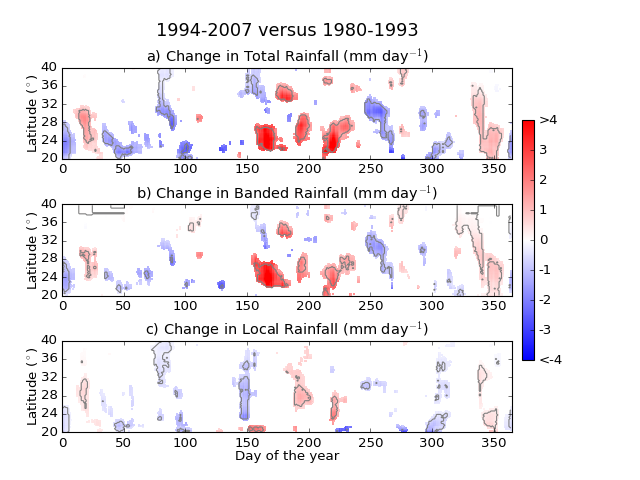

Overwriting existing version of file...
time: 12.7 s


In [13]:
## CREATE FIGURE OF 1980-1993 v 1994-2007 changes

axlim = max(np.max(abs(P_total_diff_mask[1])),np.max(abs(P_band_diff_mask[1])),np.max(abs(P_local_diff_mask[1])))
print(axlim) #used to scale colorbar
axlim = 4

fig, ax = plt.subplots()
ax.set_title("1994-2007 versus 1980-1993", fontsize=16, y = 1.07)
mypalette = 'bwr'

ax1 = fig.add_subplot(3,1,1)
plot1 = ax1.pcolormesh(P_total_diff_mask[1].T, cmap = mypalette, vmin = -axlim, vmax = axlim); 
plt.contour(mk_total[1][1].T,1,colors = 'gray')
ax1.set_title("a) Change in Total Rainfall (mm day$^{-1}$)", fontsize=13)
#plt.xlabel('Day of the year', fontsize=12, labelpad=0)
plt.ylabel('Latitude ($^\circ$)', fontsize=12, labelpad=0)
plt.yticks(np.linspace(0,80,6),np.linspace(20,40,6).astype(int))

ax2 = fig.add_subplot(3,1,2)
plot2 = ax2.pcolormesh(P_band_diff_mask[1].T, cmap = mypalette, vmin = -axlim, vmax = axlim); 
plt.contour(mk_band[1][1].T,1,colors = 'gray')
ax2.set_title("b) Change in Banded Rainfall (mm day$^{-1}$)", fontsize=13)
#plt.xlabel('Day of the year', fontsize=12, labelpad=0)
plt.ylabel('Latitude ($^\circ$)', fontsize=12, labelpad=0)
plt.yticks(np.linspace(0,80,6),np.linspace(20,40,6).astype(int))


ax3 = fig.add_subplot(3,1,3)
plot3 = ax3.pcolormesh(P_local_diff_mask[1].T, cmap = mypalette, vmin = -axlim, vmax = axlim); 
plt.contour(mk_local[1][1].T,1,colors = 'gray')
ax3.set_title("c) Change in Local Rainfall (mm day$^{-1}$)", fontsize=13)
plt.xlabel('Day of the year', fontsize=12, labelpad=0)
plt.ylabel('Latitude ($^\circ$)', fontsize=12, labelpad=0)
plt.yticks(np.linspace(0,80,6),np.linspace(20,40,6).astype(int))

plt.tight_layout(pad=0, w_pad=0, h_pad=.5)
ax.set_axis_off()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([.815, 0.25, 0.02, 0.5])
cbar = fig.colorbar(plot2, cax = cbar_ax, ticks=np.linspace(-axlim,axlim,9))
cbar.ax.set_yticklabels(['<-4',-3,-2,-1,0,1,2,3,'>4'])  # horizontal colorbar

savepath = "/Users/Siwen/RDA/chinarain_diff_notaiwan_9407_8093.pdf"

if os.path.exists(savepath):
    print("Overwriting existing version of file...")
    os.remove(savepath)


plt.savefig(savepath)

In [121]:
P_band_diff_mask[1][:,30]

masked_array(data = [-0.7308570019671321 -0.7620041339279174 -0.7956393726421715
 -0.7245778366390634 -- -- -- -- -- -- -- -- -- -- -- -- -- --
 1.0515676552068303 1.1051440968201418 1.0383498606953259
 0.9873699092467606 0.8440065716039018 -- -- -- 0.9995109887592285
 0.8574933600098106 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -2.165337804990799
 -2.315762080965978 -1.9092140250789784 -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- 2.180357079000915 2.1447306476577244 2.5547597604630594
 3.0148298873095922 2.609458075001398 -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 1.6080012415668534 1.9868781408387213 2.1060524950288686
 1.9155249939741412 1.6654

time: 5.98 ms


<IPython.core.display.Javascript object>


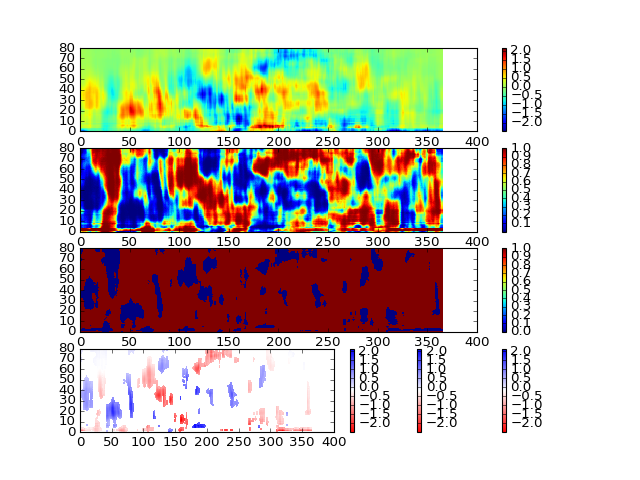

time: 357 ms


In [123]:
cmaps = ['BrBG', 'bwr', 'coolwarm', 'PiYG', 'PRGn', 'PuOr','RdBu', 'RdGy', \
                       'RdYlBu', 'RdYlGn', 'Spectral','seismic'],

fig = plt.figure()
ax1 = fig.add_subplot(4,1,1)
plot = ax1.pcolormesh(P_total_diff_smth[0].T); 
fig.colorbar(plot)

ax2 = fig.add_subplot(4,1,2)
plot = ax2.pcolormesh(P_total_diff_pval[0].T); 
fig.colorbar(plot)

ax3 = fig.add_subplot(4,1,3)
plot = ax3.pcolormesh(mk.T); 
fig.colorbar(plot)

ax4 = fig.add_subplot(4,1,4)
plot = ax4.pcolormesh(tst.T, cmap = 'bwr_r'); 
fig.colorbar(plot)



<IPython.core.display.Javascript object>


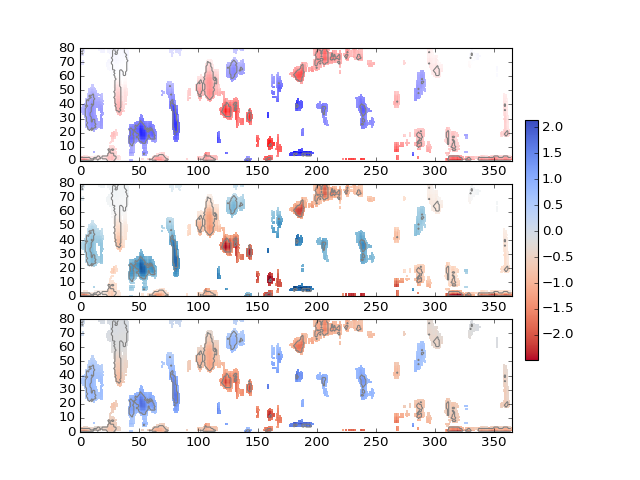

time: 13.8 s


In [70]:
cmaps = ['BrBG', 'bwr', 'coolwarm', 'PiYG', 'PRGn', 'PuOr','RdBu', 'RdGy', \
                       'RdYlBu', 'RdYlGn', 'Spectral','seismic'],
fig2 = plt.figure()

ax4 = fig2.add_subplot(3,1,1)

plot = ax4.pcolormesh(P_total_diff_mask[0].T, cmap = 'bwr_r'); 
plt.contour(mk_total[0][1].T,1,colors = 'gray')

ax5 = fig2.add_subplot(3,1,2)

plot = ax5.pcolormesh(P_total_diff_mask[0].T, cmap = 'RdBu'); 
plt.contour(mk_total[0][1].T,1,colors = 'gray')

ax6 = fig2.add_subplot(3,1,3)

plot = ax6.pcolormesh(P_total_diff_mask[0].T, cmap = 'coolwarm_r'); 
plt.contour(mk_total[0][1].T,1,colors = 'gray')

fig2.subplots_adjust(right=0.8)
cbar_ax = fig2.add_axes([0.82, 0.25, 0.02, 0.5])
fig2.colorbar(plot, cax = cbar_ax)

plt.savefig('rain_palette_test.pdf')


2.65746721782


<IPython.core.display.Javascript object>


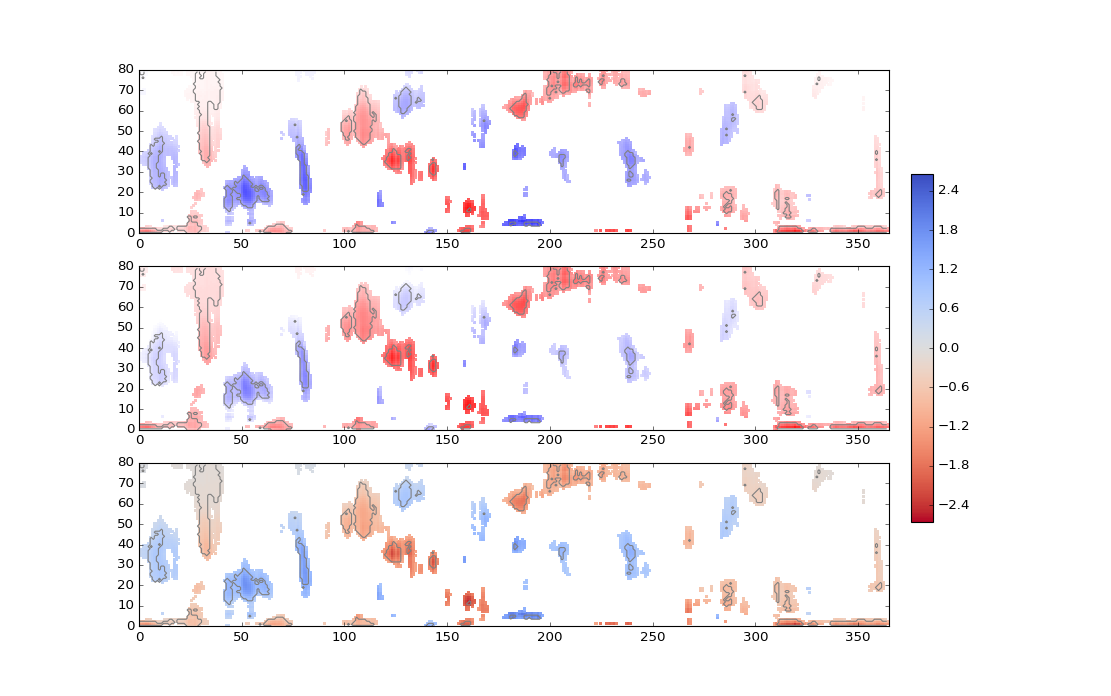

time: 11.9 s


In [27]:
axlim = max(np.max(abs(P_total_diff_mask[0])),np.max(abs(P_band_diff_mask[0])),np.max(abs(P_local_diff_mask[0])))
print(axlim) #used to scale colorbar

cmaps = ['BrBG', 'bwr', 'coolwarm', 'PiYG', 'PRGn', 'PuOr','RdBu', 'RdGy', \
                       'RdYlBu', 'RdYlGn', 'Spectral','seismic'],
fig2 = plt.figure()

ax4 = fig2.add_subplot(3,1,1)

plot = ax4.pcolormesh(P_total_diff_mask[0].T, cmap = 'bwr_r', vmin=-axlim, vmax=axlim); 
plt.contour(mk_total[0][1].T,1,colors = 'gray')

ax5 = fig2.add_subplot(3,1,2)

plot = ax5.pcolormesh(P_total_diff_mask[0].T, cmap = 'RdBu', vmin=-axlim, vmax=axlim); 
plt.contour(mk_total[0][1].T,1,colors = 'gray')

ax6 = fig2.add_subplot(3,1,3)

plot = ax6.pcolormesh(P_total_diff_mask[0].T, cmap = 'coolwarm_r', vmin=-axlim, vmax=axlim); 
plt.contour(mk_total[0][1].T,1,colors = 'gray')

fig2.subplots_adjust(right=0.8)
cbar_ax = fig2.add_axes([0.82, 0.25, 0.02, 0.5])
fig2.colorbar(plot, cax = cbar_ax)

plt.savefig('rain_palette_test_2.pdf')


<IPython.core.display.Javascript object>


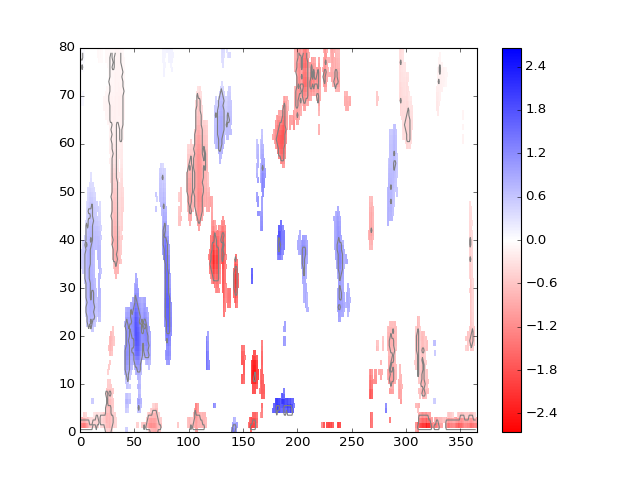

time: 4.15 s


In [37]:
fig3, ax3 = plt.subplots()

plot = ax3.pcolormesh(P_total_diff_mask[0].T, cmap = 'bwr_r', vmin=-axlim, vmax=axlim); 
plt.contour(mk_total[0][1].T,1,colors = 'gray')
fig3.colorbar(plot)

plt.savefig('rain_palette_test_3.pdf')


<IPython.core.display.Javascript object>


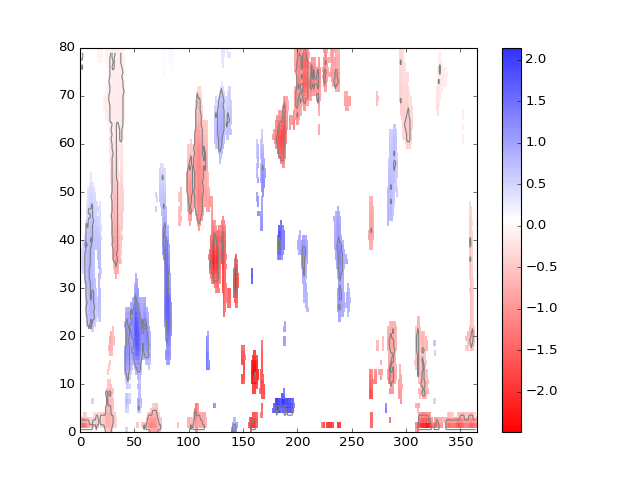

0.553836462269
0.902793575474
time: 4.03 s


In [41]:
fig4, ax4 = plt.subplots()

remap_start = 0
remap_mid = (abs(axmin))/(axmax+abs(axmin))
remap_stop = 1-(abs(axmin)-axmax)/(2*abs(axmin))

print(remap_mid)
print(remap_stop)

cmap_test = remappedColorMap(plt.cm.get_cmap('bwr_r'), start=0, midpoint=remap_mid, stop=remap_stop)

plot2 = ax4.pcolormesh(P_total_diff_mask[0].T, cmap = cmap_test); 
plt.contour(mk_total[0][1].T,1,colors = 'gray')
fig4.colorbar(plot2)

plt.savefig('rain_palette_test_4.pdf')

In [45]:
np.linspace(0,10,100)

array([  0.        ,   0.1010101 ,   0.2020202 ,   0.3030303 ,
         0.4040404 ,   0.50505051,   0.60606061,   0.70707071,
         0.80808081,   0.90909091,   1.01010101,   1.11111111,
         1.21212121,   1.31313131,   1.41414141,   1.51515152,
         1.61616162,   1.71717172,   1.81818182,   1.91919192,
         2.02020202,   2.12121212,   2.22222222,   2.32323232,
         2.42424242,   2.52525253,   2.62626263,   2.72727273,
         2.82828283,   2.92929293,   3.03030303,   3.13131313,
         3.23232323,   3.33333333,   3.43434343,   3.53535354,
         3.63636364,   3.73737374,   3.83838384,   3.93939394,
         4.04040404,   4.14141414,   4.24242424,   4.34343434,
         4.44444444,   4.54545455,   4.64646465,   4.74747475,
         4.84848485,   4.94949495,   5.05050505,   5.15151515,
         5.25252525,   5.35353535,   5.45454545,   5.55555556,
         5.65656566,   5.75757576,   5.85858586,   5.95959596,
         6.06060606,   6.16161616,   6.26262626,   6.36

time: 3.93 ms


In [ ]:
## Extra testing module: Should we expect the rainfall changes to be different or not?
